In [1]:
import os
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from google.colab import files

In [2]:
df = pd.read_csv("Walmart.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [4]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [14]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Store', 'Date']).reset_index(drop=True)
print(df.head(-1))
print(df.columns)

      Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0         1 2010-02-12    1641957.44             1        38.51       2.548   
1         1 2010-02-19    1611968.17             0        39.93       2.514   
2         1 2010-02-26    1409727.59             0        46.63       2.561   
3         1 2010-03-05    1554806.68             0        46.50       2.625   
4         1 2010-03-12    1439541.59             0        57.79       2.667   
...     ...        ...           ...           ...          ...         ...   
6384     45 2012-09-21     723086.20             0        65.32       4.038   
6385     45 2012-09-28     713173.95             0        64.88       3.997   
6386     45 2012-10-05     733455.07             0        64.89       3.985   
6387     45 2012-10-12     734464.36             0        54.47       4.000   
6388     45 2012-10-19     718125.53             0        56.47       3.969   

             CPI  Unemployment  year  month  week  

In [6]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['week'] = df['Date'].dt.isocalendar().week.astype(int)

df['lag_1'] = df.groupby('Store')['Weekly_Sales'].shift(1)
df['lag_52'] = df.groupby('Store')['Weekly_Sales'].shift(52)
df['roll_4'] = df.groupby('Store')['Weekly_Sales'].shift(1).rolling(window=4, min_periods=1).mean()

df = df[df['lag_1'].notna()].copy()

In [7]:
df.head(2)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,week,lag_1,lag_52,roll_4
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,6,1643690.90,NaN,1643690.90
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,7,1641957.44,NaN,1642824.17


In [8]:
FEATURES = [
    'Store',
    'Holiday_Flag',
    'Temperature',
    'Fuel_Price',
    'CPI',
    'Unemployment',
    'year',
    'month',
    'week',
    'lag_1',
    'lag_52',
    'roll_4'
]
TARGET = 'Weekly_Sales'

In [9]:
#  Train/Val split (last 12 weeks validation)

val_weeks = 12
max_date = df['Date'].max()
cuttoff = max_date - pd.Timedelta(weeks=val_weeks)

train = df[df['Date'] <= cuttoff].copy()
test = df[df['Date'] > cuttoff].copy()

X_train , y_train = train[FEATURES] , train[TARGET]
X_test , y_test = test[FEATURES] , test[TARGET]

print("Train Rows : ",len(train),"Test Rows : ",len(test))

Train Rows :  5850 Test Rows :  540


In [10]:
from re import VERBOSE
# Train LGBM WITHOUT early stopping (safe)
# Increase n_estimators for robust training; you can reduce if slow.

model = LGBMRegressor(
    objective='regression',
    learning_rate = 0.05,
    num_leaves = 50,
    feature_fraction = 0.9,
    bagging_fraction = 0.9,
    bagging_freq = 3,
    n_estimators=500,
    random_state = 42,
    verbose = -1
)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

In [11]:
# Validation Accuracy


rmse = np.sqrt(((y_test - y_pred) ** 2).mean())
print(f"RMSE : {rmse:.2f}")

y_temp = test.copy()

y_temp['Pred'] = y_pred
agg_val = y_temp.groupby('Date')[['Weekly_Sales','Pred']].sum().reset_index()

RMSE : 51907.25


In [12]:
agg_val

,Date,Weekly_Sales,Pred
0,2012-08-10,47403451.04,4.659435e+07
1,2012-08-17,47354452.05,4.727238e+07
2,2012-08-24,47447323.60,4.754419e+07
3,2012-08-31,47159639.43,4.742264e+07
4,2012-09-07,48330059.31,4.868942e+07
5,2012-09-14,44226038.65,4.499375e+07
6,2012-09-21,44354547.11,4.382475e+07
7,2012-09-28,43734899.40,4.322740e+07
8,2012-10-05,47566639.31,4.829679e+07
9,2012-10-12,46128514.25,4.571050e+07


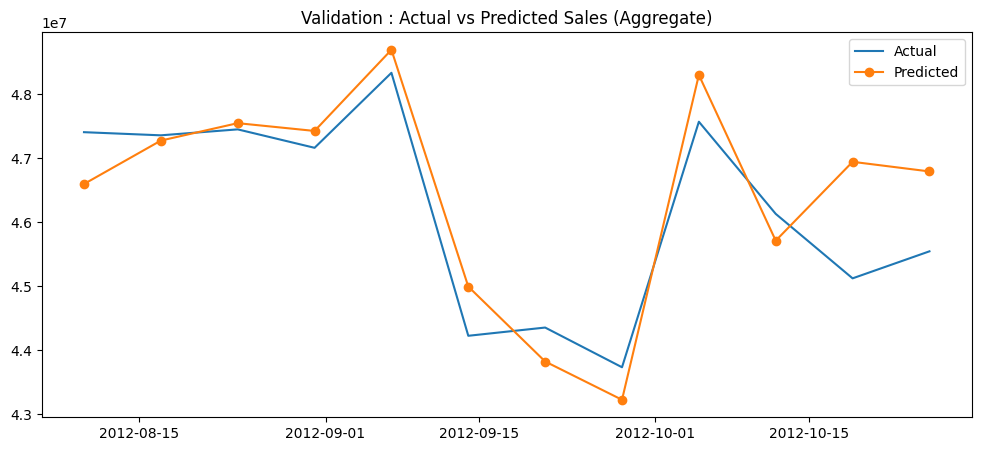

In [13]:
# Visualization

plt.figure(figsize=(12,5))
plt.plot(agg_val['Date'],agg_val['Weekly_Sales'],label='Actual')
plt.plot(agg_val['Date'],agg_val['Pred'],label='Predicted',marker='o')
plt.title('Validation : Actual vs Predicted Sales (Aggregate)')
plt.legend()
plt.show()